Submitted by:

Lior Maltz - 318307923
Alon Papini - 205815962

**Imports cell**

In [1]:
# Object imports
import numpy as np
import pandas as pd
import torch

# Image handle imports
import cv2
from PIL import Image

# Data handle imports
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

# Plot and presentation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Others
import torch.nn as nn
from torchvision import transforms
import os
import zipfile
import random
import io
import time

In [2]:
# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The file 'all_data_info.csv' stores all the information about the data we will use in our Siamese model.
With a CSV reader variable we could investigate the data, and from there decide how to build the model.

In [3]:
# CSV variable
all_data_csv = pd.read_csv('../Data/CSV/all_data_info.csv')
# Look at the first 20 images of the data
all_data_csv.head(20)

artist    date                     genre  pixelsx  \
0              Barnett Newman  1955.0                  abstract  15530.0   
1              Barnett Newman  1950.0                  abstract  14559.0   
2                 kiri nichol  2013.0                       NaN   9003.0   
3                 kiri nichol  2013.0                       NaN   9003.0   
4                 kiri nichol  2013.0                       NaN   9003.0   
5               Tosa Mitsuoki     NaN     mythological painting  25528.0   
6              Barnett Newman     NaN                  abstract   7345.0   
7                   Hiroshige    1838  bird-and-flower painting   6483.0   
8              Barnett Newman  1963.0                  abstract   6049.0   
9   Franz Richard Unterberger     NaN                 cityscape   6238.0   
10                  Hiroshige    1844  bird-and-flower painting   5492.0   
11            Wolfgang Paalen  1937.0                 landscape   5331.0   
12                     Mabuse     NaN        religious painting   5259.0   
13           Utagawa Kunisada     NaN                 landscape   9293.0   
14            Ivan Aivazovsky    1873                    marina   7444.0   
15              Paul Serusier    1890            genre painting   7099.0   
16                  Hiroshige    1838  bird-and-flower painting   4256.0   
17                  Hiroshige     NaN  bird-and-flower painting   4154.0   
18           Hieronymus Bosch    1515        religious painting   8533.0   
19                  Hiroshige    1850  bird-and-flower painting   4045.0   

    pixelsy  size_bytes   source                 style  \
0    6911.0   9201912.0  wikiart  Color Field Painting   
1    6866.0   8867532.0  wikiart  Color Field Painting   
2    9004.0   1756681.0      NaN         Neoplasticism   
3    9004.0   1942046.0      NaN         Neoplasticism   
4    9004.0   1526212.0      NaN         Neoplasticism   
5    3000.0  10496349.0  wikiart              Yamato-e   
6    8640.0   6383948.0  wikiart  Color Field Painting   
7    9276.0  12762418.0  wikiart               Ukiyo-e   
8    8206.0   1135960.0  wikiart  Color Field Painting   
9    7352.0   7896792.0  wikiart           Romanticism   
10   8283.0  10736273.0  wikiart               Ukiyo-e   
11   8351.0   1407667.0  wikiart            Surrealism   
12   8400.0   1489790.0  wikiart  Northern Renaissance   
13   4688.0  10274760.0  wikiart               Ukiyo-e   
14   5811.0   3189597.0  wikiart           Romanticism   
15   5857.0   9803854.0  wikiart           Cloisonnism   
16   9127.0   6483189.0  wikiart               Ukiyo-e   
17   9051.0   5964682.0  wikiart               Ukiyo-e   
18   4325.0   6675952.0  wikiart  Northern Renaissance   
19   8999.0   5930496.0  wikiart               Ukiyo-e   

                                                title    artist_group  \
0                                               Uriel      train_only   
1                               Vir Heroicus Sublimis      train_only   
2                                                 NaN       test_only   
3                                                 NaN       test_only   
4                                                 NaN       test_only   
5         Night March of a Hundred Demons (left half)      train_only   
6            Who’s Afraid of Red,  Yellow and Blue II      train_only   
7               Small Bird on a Branch of Kaidozakura  train_and_test   
8                                       Black Fire I       train_only   
9                               Procession in Naples   train_and_test   
10                          Camellia and Bush Warbler  train_and_test   
11                                    Forbidden Land       train_only   
12                             Descent from the cross      train_only   
13  Snowy landscape with a woman brandishing a bro...      train_only   
14                                       Storm at sea  train_and_test   
15                                   Se

Here we'll do initial parsing of the data to better understand what we're up against.

In [4]:
total_num = len(all_data_csv)
train_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_only'])
test_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'test_only'])
train_and_test_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_and_test'])

artist_num = len(all_data_csv['artist'].unique())
genres_num = len(all_data_csv["genre"].dropna().unique())

pixelsx_mean = all_data_csv["pixelsx"].mean()
pixelsx_var = all_data_csv["pixelsx"].var()
pixelsx_max = int(all_data_csv["pixelsx"].max())
pixelsx_min = int(all_data_csv["pixelsx"].min())

pixelsy_mean = all_data_csv["pixelsy"].mean()
pixelsy_var = all_data_csv["pixelsy"].var()
pixelsy_max = int(all_data_csv["pixelsy"].max())
pixelsy_min = int(all_data_csv["pixelsy"].min())

average_paints_per_artist = all_data_csv['artist'].value_counts().mean()


#print(all_data_csv['artist'].value_counts())
# To check number of images with not NaN genre value
#Nan_genres_num = len(all_data_csv.loc[pd.isna(all_data_csv["genre"]) == False])

print(f'Total number of images in the data: {total_num}')
print(f'The Split of the data between Train only/Train and Test/ Test only is: {train_only_num}/{train_and_test_num}/{test_only_num}\n')

print(f'Number of different genres: {genres_num}')
print(f'Average paints per artist in this set: {average_paints_per_artist:.2f}\n')

print(f'The average size of X axis per image is {pixelsx_mean:.2f} pixel, and average size of Y axis per image is {pixelsy_mean:.2f}')
print(f'The highest (X, Y) measurements are ({pixelsx_max}, {pixelsy_max}), and the lowest are ({pixelsx_min}, {pixelsy_min})')
print(f'The variances of the axis measurements are ({pixelsx_var:.2f}, {pixelsy_var:.2f})')

Total number of images in the data: 103250
The Split of the data between Train only/Train and Test/ Test only is: 14164/86150/2936

Number of different genres: 42
Average paints per artist in this set: 44.52

The average size of X axis per image is 960.81 pixel, and average size of Y axis per image is 984.09
The highest (X, Y) measurements are (25528, 9541), and the lowest are (200, 162)
The variances of the axis measurements are (355538.29, 390799.19)


Next up, a presentation of some random images from the dataset.
Note: Not all the images are presented in their correct color format.

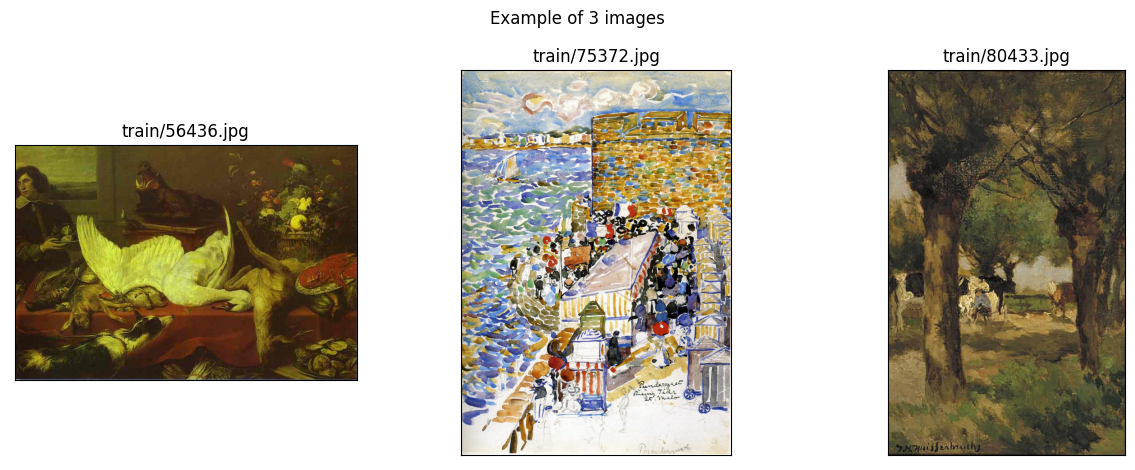

In [5]:
plt.figure(figsize=(15,5))

for i in range(1,4):
    # choose a image file randomly from the training data

    # unzip image with color conversion
    archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
    random_image_name = random.choice(archive.namelist())
    image_data = archive.open(random_image_name)
    image = Image.open(image_data)

    # presenting the 3 images in a row
    plt.subplot(1, 3, i)
    plt.title(random_image_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.asarray(image))

plt.suptitle(f"Example of {3} images", y=1.001)
plt.show()

One of the things we tried to help simplify / shorten the training duration is to fix the resolution of all images to one specific size, usually smaller than their original size.

In [6]:
def resolution_fixture(path_from, path_to, file_name, new_res=256):
    images = []
    i1 = 0
    archive = zipfile.ZipFile(path_from + '/' + file_name + '.Zip', 'r')
    # first we extract all the files from a given zip file and then store them in a list of items in the form of [file_name, file_in bytes]
    for current_file_path in archive.namelist():
        if (i1) % 500 == 0:
            print(f"{i1} images processed")
        i1 += 1
        # separate the names
        if not "jpg" in current_file_path:
            continue
        else:
            image_name = current_file_path[len(file_name)+1:]

        try:

            file_object = io.BytesIO()
            image_data = archive.open(current_file_path)
            image = Image.open(image_data)
            tensor_image = transforms.Compose([transforms.ToTensor(), transforms.Resize((new_res, new_res))])(image)
            image = transforms.ToPILImage()(tensor_image)
            # save in file object buffer
            image.save(file_object, 'PNG')
            image.close()
            images.append([image_name, file_object])

        except Image.DecompressionBombError:
                print(f"DecompressionBombError in file {image_name}")
        except Exception as e:
            print(f" Error received in image {image_name}")
            print(f" Error massage: {str(e)}")


    #zip_file_bytes_io = io.BytesIO()
    #zip_file = zipfile.ZipFile(path_to + '/' + file_name + '.zip', 'w')

    with zipfile.ZipFile(path_to + '/' + file_name + '_' + str(new_res) + '.zip', 'w') as zip_obj:
        for image_name, bytes_stream in images:
            zip_obj.writestr(file_name + '/' + image_name, bytes_stream.getvalue())


# if True - Run the zip creation code of scaled resolution images
if False:
    for i in range (2,7):
        path_from = "../Data/Zips"
        path_to = "../Data/Zips/Fixed_Zips"
        file_name = "train_" + str(i)
        new_res = 256
        resolution_fixture(path_from, path_to, file_name, new_res)

First, We should classify our data by train and test data

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# if the data frame is not yet defined we can extract it from files if it is already stored there.
# if the data frame is not saved in files either, we will make it from scratch.
if not os.path.isfile("../Data/Variables/train_data_frame.pkl"):
    # We will train our model only with artists that have more than 10 paintings labeled under their name.
    paints_per_painter = all_data_csv['artist'].value_counts()
    #a =  all_data_csv.items()
    #paints_per_painter = all_data_csv.items()['artist'].value_counts()
    #print(paints_per_painter)
    actual_artist_list = [paints_per_painter.index[i] for i in range(len(paints_per_painter)) if paints_per_painter[i] > 10]

    # Here we are classifying the data by train and test paintings, as they presented in the CSV file.
    # We choose only the paintings of artists with more than 10 paintings to their name for the sake of easier training.
    train_data_frame = pd.DataFrame({})
    test_data_frame = pd.DataFrame({})
    i1 = 0
    for artist in actual_artist_list:
        i1 += 1
        artist_data = all_data_csv[(all_data_csv['artist']==artist)]
        artist_train_data = artist_data.loc[(artist_data.in_train == True)]
        artist_test_data = artist_data.loc[(artist_data.in_train == False)]
        train_data_frame = pd.concat([train_data_frame, artist_train_data])
        test_data_frame = pd.concat([test_data_frame, artist_test_data])

    train_data_frame.to_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame.to_pickle("../Data/Variables/test_data_frame.pkl")

else:
    train_data_frame = pd.read_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame = pd.read_pickle("../Data/Variables/test_data_frame.pkl")

In [8]:
# define 10 mini training sets for training 10 mini networks from the most frequent artists in train data set, and also make a validation set from the remaining artists
if False:
    train_data_frame_count = train_data_frame["artist"].value_counts()[:300]
    filtered_data_frame = train_data_frame[train_data_frame['artist'].isin(list(train_data_frame_count.index))].reset_index(drop=True)
    for i in range(10):
        chosen_artists = np.random.choice(filtered_data_frame["artist"].unique(), 20)
        current_data_frame = filtered_data_frame[filtered_data_frame['artist'].isin(list(chosen_artists))]

        mask = filtered_data_frame['artist'].isin(current_data_frame['artist'])
        filtered_data_frame = filtered_data_frame[~mask].reset_index(drop=True)
        current_data_frame.to_pickle(f"../Data/Variables/train_data_frame{i}.pkl")
    filtered_data_frame.to_pickle(f"../Data/Variables/validation_data_frame.pkl")

In [11]:
# This code box should show in numbers how many usable images and artists there are per each dataset.
train_artists = list(train_data_frame["artist"].unique())
mask = test_data_frame['artist'].isin(train_artists)
test_data_frame = test_data_frame[~mask].reset_index(drop=True)
validation_data_frame = pd.read_pickle("../Data/Variables/validation_data_frame.pkl")
datasets_stats = pd.DataFrame({'Datasets': ['train_data_frame', 'validation_data_frame', 'test_data_frame'],
    'Number of images': [len(train_data_frame), len(validation_data_frame), len(test_data_frame)],
    'Number of artist': [len(train_data_frame["artist"].unique()), len(validation_data_frame["artist"].unique()), len(test_data_frame["artist"].unique())]})
datasets_stats.head()

Datasets  Number of images  Number of artist
0       train_data_frame             77561              1418
1  validation_data_frame             17593               108
2        test_data_frame              2899                86

These are dataloader classes, separate for each type of loss function: Contrastive and Triplet.
Either way, these dataloaders will be used to for the models to properly interact with the data.

In [10]:
# An idea is to inherit from a root class for the definition of the SingleDataSet and TripletDataSet loss classes.
class RootDataSet:
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.data_frame = data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"
            self.train_zip_name += '/'

        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')

        if is_train:
            self.filter_data_frame(min_paints_artist=40, max_paints_artist=10000, most_frequent=None)
        else:
            self.filter_data_frame(min_paints_artist=0, max_paints_artist=1000000, most_frequent=None)
        self.train_images_files = self.data_frame.iloc[:, 11].values
        self.train_labels = self.data_frame.iloc[:, 0].values
        self.train_index = self.data_frame.index.values

        #if is_train:
        self.choose_n_to_visualization(150, 15)

    # With this function we choose only artists with a set range of paintings to their name.
    def filter_data_frame(self, min_paints_artist, max_paints_artist, most_frequent = None):
        #
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = self.data_frame.loc[self.data_frame['new_filename'].isin(image_name_list)]
        data_frame_count = self.data_frame["artist"].value_counts()[:most_frequent]
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_frame_count[data_frame_count > min_paints_artist].index) & self.data_frame['artist'].isin(data_frame_count[data_frame_count < max_paints_artist].index)]
        self.data_frame = self.data_frame.reset_index(drop=True)

    # With this function we choose n images from a number of artists with the largest number of paintings to be visualized in the 3D graphs we plot later in the notebook, when we train and evaluate models.
    def choose_n_to_visualization(self, n, num_artist=15):
        data_frame_count = self.data_frame["artist"].value_counts()[:num_artist]
        data_frame_vis = self.data_frame[self.data_frame['artist'].isin(data_frame_count.index)].reset_index(drop=True)
        train_index_vis = data_frame_vis.index.values
        train_labels_vis = data_frame_vis.iloc[:, 0].values

        indices = np.random.choice(train_index_vis, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = train_labels_vis[index]

            image = self.toTensor(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]
            image = self.normalize(image)

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels

    def remove_validation_data(self, data_to_remove):

        mask = self.data_frame['new_filename'].isin(data_to_remove['new_filename'])

        # invert the mask to select the rows that should remain in df1
        self.data_frame = self.data_frame[~mask]
        self.data_frame = self.data_frame.reset_index(drop=True)

# debug stuff
#obj = RootDataSet("train", train_data_frame, fixed_res=True, res_size=256)
#obj2 = RootDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#obj.remove_validation_data(obj2.data_frame)



In [11]:
# Contrastive loss dataloader definition, inherits from RootDataSet
class SingleDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, data_frame, fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three images, for both the image and the label
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            # transform the image to a specific dimension
            anchor_image = self.toTensor(anchor_image)

            # Every image will be shaped to having exactly 3 channels
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            anchor_image = self.normalize(anchor_image)

            return anchor_image, anchor_label

        # In case label = -1 it's a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, self.res_size, self.res_size), "None_label"
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, self.res_size, self.res_size), "None_label"


In [12]:
#  Double dataloader definition, inherits from RootDataSet
class DoubleDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, data_frame, fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)

    # each iteration we will bring a pair of images, and a label which indicate if they came from the same artist (1), or not (0)
    def __getitem__(self, index):
        try:

            # Extraction process of the three images for the current item
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]


            label = random.randint(0, 1)
            # choose between positive and negative
            if label:
                bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
                second_list = np.array(self.train_index[self.train_index!=index])
                second_list = second_list[bool_list]
                # In case there aren't any images in the positive list, item don't have a positive partner
                if(len(second_list) == 0):
                    raise Exception("No matching image for anchor")
                else:
                    positive_index = random.choice(second_list)

                second_file_name = self.train_images_files[positive_index]
                second_image_data = self.train_archive.open(self.train_zip_name + second_file_name)
                second_image = Image.open(second_image_data)

            else:
                second_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
                second_index = random.choice(second_list)
                second_file_name = self.train_images_files[second_index]
                second_image_data = self.train_archive.open(self.train_zip_name + second_file_name)
                second_image = Image.open(second_image_data)


            anchor_image = self.toTensor(anchor_image)
            second_image = self.toTensor(second_image)

            # Every image will be shaped to having exactly 3 channels
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if second_image.shape[0] == 1:
                second_image = torch.cat([second_image, second_image, second_image], 0)
            if second_image.shape[0] == 4:
                second_image = second_image[0:3]

            anchor_image = self.normalize(anchor_image)
            second_image = self.normalize(second_image)

            ret_tensor = torch.stack(([anchor_image, second_image]))
            return ret_tensor, float(label)

        # In case label = -1 it's a signal to not forward the sample
        except Exception as e:
            print(f"could not load a file")
            print(f"Error message: {e}")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"


## to debug
#obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i == 100:
#        print("done")
#        break
#    i +=1


In [13]:
# inspiration from https://www.kaggle.com/code/spyrosrigas/20-painters-classification-with-cnns-and-svms
# Triplet loss dataloader definition, inherits from RootDataSet
class TripletDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, data_frame, fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, data_frame, fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        try:

            # Extraction process of the three images for the current item
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # In case there aren't any images in the positive list, item don't have a positive partner
            if(len(positive_list) == 0):
                raise Exception("No matching image for anchor")
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            if self.train_labels[positive_index] != self.train_labels[index]:
                print("Positive and anchor don't have the same label, so... Mismatch?")

            if self.train_labels[negative_index] == self.train_labels[index]:
                print("Negative and anchor have the same label, so... Mismatch?")

            anchor_image = self.toTensor(anchor_image)
            positive_image = self.toTensor(positive_image)
            negative_image = self.toTensor(negative_image)

            # Every image will be shaped to having exactly 3 channels
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            anchor_image = self.normalize(anchor_image)
            positive_image = self.normalize(positive_image)
            negative_image = self.normalize(negative_image)

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return ret_tensor, anchor_label

        # In case label = -1 it's a signal to not forward the sample
        except Exception as e:
            print(f"could not load a file")
            print(f"Error message: {e}")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), "None_label"


## to debug
#obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i == 100:
#        print("done")
#        break
#    i +=1


The following code block was used to test how long the data loader classes took to run.

In [14]:
if False:
    start_time = time.perf_counter()

    obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
    data_loader = DataLoader(obj, batch_size=32, num_workers=0, shuffle=True)
    i = 0
    for inputs, labels in data_loader:
        #print(inputs.shape)
        #print(labels)
        if i == 63:
            break
        i += 1
        if i % 10 == 0:
            print(f"done {i}")

    end_time = time.perf_counter()
    print(f"{end_time - start_time:0.2f} seconds")


In [15]:
# This class calculates triplet loss. Even though PyTorch has it built-in, we still made our own version.
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean(), predictions

    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()


In [16]:
class Network2(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(Network2, self).__init__()
        self.conv_layers = nn.Sequential(
             nn.Conv2d(3, 32, kernel_size=3),
             #nn.BatchNorm2d(32),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(32, 64, kernel_size=3),
             #nn.BatchNorm2d(64),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(64, 128, kernel_size=3),
             #nn.BatchNorm2d(128),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
             nn.Conv2d(128, 256, kernel_size=3),
             #nn.BatchNorm2d(256),
             nn.ReLU(inplace=True),
             nn.MaxPool2d(kernel_size=2, stride=2),
         )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layers(x)
        return x

In [17]:
# An attempt at a siamese CNN that determines if paintings have an identical artist or not.
class Network(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(Network, self).__init__()
        self.criterion = TripletLoss()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, 6),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(128*28*28, 512),
            nn.PReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [18]:
# An attempt at a siamese CNN that determines if paintings have an identical artist or not.
class FinalNetwork(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super(FinalNetwork, self).__init__()
        self.Net0 = Network2()
        checkpoint = torch.load("../Data/Models/Net0.pth")
        self.Net0.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net0.parameters():
            parameter.requires_grad = False

        self.Net1 = Network2()
        checkpoint = torch.load("../Data/Models/Net1.pth")
        self.Net1.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net1.parameters():
            parameter.requires_grad = False

        self.Net2 = Network2()
        checkpoint = torch.load("../Data/Models/Net2.pth")
        self.Net2.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net2.parameters():
            parameter.requires_grad = False

        self.Net3 = Network2()
        checkpoint = torch.load("../Data/Models/Net3.pth")
        self.Net3.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net3.parameters():
            parameter.requires_grad = False

        self.Net4 = Network2()
        checkpoint = torch.load("../Data/Models/Net4.pth")
        self.Net4.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net4.parameters():
            parameter.requires_grad = False


        self.Net5 = Network2()
        checkpoint = torch.load("../Data/Models/Net5.pth")
        self.Net5.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net5.parameters():
            parameter.requires_grad = False

        self.Net6 = Network2()
        checkpoint = torch.load("../Data/Models/Net6.pth")
        self.Net6.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net6.parameters():
            parameter.requires_grad = False

        self.Net7 = Network2()
        checkpoint = torch.load("../Data/Models/Net7.pth")
        self.Net7.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net7.parameters():
            parameter.requires_grad = False

        self.Net8 = Network2()
        checkpoint = torch.load("../Data/Models/Net8.pth")
        self.Net8.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net8.parameters():
            parameter.requires_grad = False

        self.Net9 = Network2()
        checkpoint = torch.load("../Data/Models/Net9.pth")
        self.Net9.load_state_dict(checkpoint["model_state_dict"])
        for parameter in self.Net9.parameters():
            parameter.requires_grad = False

        self.fc = nn.Sequential(
            nn.Linear(1024*10, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512)
        )

    def forward_once(self, x, model):
        x = model(x)
        return x.view(x.shape[0], -1)

    def forward(self, x):
        x0 = self.forward_once(x, self.Net0)
        x1 = self.forward_once(x, self.Net1)
        x2 = self.forward_once(x, self.Net2)
        x3 = self.forward_once(x, self.Net3)
        x4 = self.forward_once(x, self.Net4)
        x5 = self.forward_once(x, self.Net5)
        x6 = self.forward_once(x, self.Net6)
        x7 = self.forward_once(x, self.Net7)
        x8 = self.forward_once(x, self.Net8)
        x9 = self.forward_once(x, self.Net9)


        x = self.fc(torch.cat([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9], dim=1))
        return x

In [19]:
# This function is the part where, given a model and a specific data loader, we compare what the model has to say about inputs belonging to the same artist or not and the ground truth.
def test_run_triplet(test_loader, model, set_type = "training", criterion = TripletLoss()):
    attempts = 0
    successes = 0

    loss_list = []

    for step, (inputs, labels) in tqdm(enumerate(test_loader), desc="Steps"):
        #if (step + 1) % 5 == 0:
        if ((step + 1) % 50 == 0 and set_type != "test"):
            break

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        anchor_img = inputs[:, 0, :, :, :]
        positive_img = inputs[:, 1, :, :, :]
        negative_img = inputs[:, 2, :, :, :]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss, prediction = criterion.predict(anchor_out, positive_out, negative_out)
        loss_list.append(loss.cpu().detach().numpy())
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]
    success_rate = successes/attempts
    if set_type == "validation":
        print(f"Validation success rate: {(success_rate):0.2f}")
    elif set_type == "train":
        print(f"Training success rate: {(success_rate):0.2f}")
    elif set_type == "test":
        print(f"Test success rate: {(success_rate):0.2f}")
    #input("Press Enter to continue...")

    return np.mean(loss_list), success_rate


#obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#model = Network().to(device)
#test_run(data_loader, model)

In [20]:
# This function is the part where, given a model and a specific data loader, we compare what the model has to say about inputs belonging to the same artist or not and the ground truth.
def test_run_pairs(test_loader, model, set_type = "training", criterion = TripletLoss().to(device)):
    attempts = 0
    successes = 0

    loss_list = []

    for step, (inputs, labels) in tqdm(enumerate(test_loader), desc="Steps"):
        #if (step + 1) % 5 == 0:
        if ((step + 1) % 50 == 0 and set_type != "test"):
            break

        # if one of the label is sign of a bad image, we will pass the step
        to_continue = False
        for i in range(len(labels)):
            if labels[i] == "None_label":
                to_continue=True
        if to_continue:
            continue

        first_img = inputs[:, 0, :, :, :].to(device)
        second_img = inputs[:, 1, :, :, :].to(device)

        first_emb = model(first_img)
        second_emb = model(second_img)

        distances = (first_emb - second_emb).pow(2).sum(1)
        predictions = (distances < 0.4).int().cpu().view(-1)

        successes += sum(predictions == labels.int()).item()
        attempts += labels.shape[0]

    success_rate = successes/attempts
    if set_type == "validation":
        print(f"Validation success rate: {(success_rate):0.2f}")
    elif set_type == "train":
        print(f"Training success rate: {(success_rate):0.2f}")
    elif set_type == "test":
        print(f"Test success rate: {(success_rate):0.2f}")
    #input("Press Enter to continue...")

    return success_rate


3-d visualization cell

In [21]:
from sklearn.decomposition import PCA
# This class helps generate a 3D graph, for visualization during the training stages. We do so by using PCA to get the 3 most important values that define an image.
def visualization_3d(model, data_loader_object):
    pca = PCA(n_components=3)
    batch_size = 2
    n_images = data_loader_object.n_images
    labels = data_loader_object.labels
    #embedded_image_list = np.empty([0, 1024])
    embedded_image_list = np.empty([0, 512])
    for i in range(0, int(len(n_images)/batch_size) - 1):
        x = torch.empty((0,3,256,256))
        for j in range(batch_size):
            x = torch.cat([x, n_images[i*batch_size+j].reshape(1,3,256,256)], 0)
        #x = torch.cat([n_images[i].reshape(1,3,256,256), n_images[i].reshape(1,3,256,256)], 0)
        embedded_image = model(x.to(device))
        embedded_image_list = np.append(embedded_image_list, embedded_image.cpu().detach().numpy(), 0)
    principalComponents = pca.fit_transform(embedded_image_list)

    principalDf =pd.DataFrame(data = principalComponents, columns = ['pc1',  'pc2', 'pc3'])
    labelDf = pd.DataFrame(labels)
    principalDf = pd.concat([principalDf,labelDf],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["pc1", "pc2", "pc3", "label"]

    # Create 3D container
    ax = plt.axes(projection = '3d')
    # Visualize 3D scatter plot
    unique_labels = principalDf["label"].unique()
    name_to_int = {name: i for i, name in enumerate(set(unique_labels))}
    integers = [name_to_int[name] for name in unique_labels]
    labels_colors = [(i - min(integers))/(max(integers) - min(integers))*255 for i in integers]
    labels_colors_dict = dict(zip(unique_labels, labels_colors))
    name_lengths_list = [labels_colors_dict[labels] for labels in principalDf["label"]]
    ax.scatter3D(principalDf["pc1"], principalDf["pc2"], principalDf["pc3"], c = name_lengths_list, cmap='gist_rainbow')
    # Give labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

# for debugging purposes:
if False:
    model = Network().to(device)
    triplet_obj = TripletDataSet("train_1", train_data_frame, fixed_res=True, res_size=256)
    for i in range(5):
        visualization_3d(model, triplet_obj)

In [22]:
# This code cell has functions that help find and calculate "hard batches" - triplets such that the positive image is far away from the anchor, and the negative image is close to the anchor. Using hard batches should help us train a better model.

def get_embeddings(model, inputs, out_dim):
    inputs = inputs.to(device)
    embeddings = torch.empty(0, out_dim)
    for i in range(len(inputs)):
        embeddings = torch.cat([embeddings, model(inputs[i].to(device))], 0)
    return embeddings

# here a matrix of (batch_size, batch_size) will store the distances between all the embedding vectors
def _pairwise_distances(embeddings):
    dot_product = torch.matmul(embeddings, embeddings.t())
    square_norm = torch.diag(dot_product)
    distances = torch.unsqueeze(square_norm, 0) - 2.0 * dot_product + torch.unsqueeze(square_norm, 1)
    distances = torch.clamp(distances, min=0.0)

    return distances

# return matrix if the size (batch_size, batch_size), with True only in the cells of positive items
def _get_anchor_positive_triplet_mask(labels):
    mask = torch.empty(0, len(labels))
    for i in range(len(labels)):
        bool_list = torch.tensor([[label == labels[i] for label in labels]])
        mask = torch.cat([mask, bool_list])
    return mask

# return matrix if the size (batch_size, batch_size), with True only in the cells of negative items
def _get_anchor_negative_triplet_mask(labels):
    mask = torch.empty(0, len(labels))
    for i in range(len(labels)):
        bool_list = torch.tensor([[label != labels[i] for label in labels]])
        mask = torch.cat([mask, bool_list])
    return mask


# This code will find the hardest negative and positive for every input, and will compute with them triplet loss
def batch_hard_triplet_loss(labels, embeddings, margin):

    # Get the pair wise distance matrix
    pairwise_dist = _pairwise_distances(embeddings)

    # For each anchor, get the hardest positive (the farthest one), by filtering only the positive items with a boolean mask
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = mask_anchor_positive.to(torch.float32)
    anchor_positive_dist = mask_anchor_positive.to(device) * pairwise_dist
    # shape (batch_size, 1)
    hardest_positive_dist, _ = torch.max(anchor_positive_dist, dim=1, keepdim=True)
     # For each anchor, get the hardest negative item (the closest one), by filtering only the negative items with a boolean mask
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = mask_anchor_negative.to(torch.float32)
    max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative.to(device))
    # shape (batch_size,)
    hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

    # triplet loss computations
    triplet_loss = torch.relu(hardest_positive_dist - hardest_negative_dist + margin)
    triplet_loss = torch.mean(triplet_loss)
    return triplet_loss

In [23]:
def train(train_data_frame, validation_data_frame, model, model_name, epochs = 80, batch_size = 24, current_training_zip = "train", hard_batch = False, step_break = 300):
    # Initialization of several variables
    lr_patience = 2
    lr_steps = lr_patience
    min_loss = 100000000
    min_validation_loss = 100000000
    early_stopping_patience = 7
    patience_steps = early_stopping_patience

    epochs_num = 0

    #model = Network().to(device)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    triplet_loss = TripletLoss(0.25).to(device)

    #all_training_zips = ["train_1", "train_2", "train_3", "train_4", "train_5", "train_6", "train_7", "train_8", "train_9"]
    #all_training_zips = ["train_1", "train_2", "train_3", "train_4", "train_5"]
    #validation_zip = random.choice(all_training_zips)
    #all_training_zips.remove(validation_zip)

    validation_loader_object = TripletDataSet(current_training_zip, validation_data_frame, fixed_res=True, res_size=256)
    validation_loader = DataLoader(validation_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

    #def set_loader():
        #current_training_zip = random.choice(all_training_zips)

    def remove_parts_from_data(train_loader_object):

        loader_object_to_remove_1 = TripletDataSet("train_6", train_data_frame, fixed_res=True, res_size=256, is_train=False)
        loader_object_to_remove_2 = TripletDataSet("train_7", train_data_frame, fixed_res=True, res_size=256, is_train=False)
        loader_object_to_remove_3 = TripletDataSet("train_8", train_data_frame, fixed_res=True, res_size=256, is_train=False)
        loader_object_to_remove_4 = TripletDataSet("train_9", train_data_frame, fixed_res=True, res_size=256, is_train=False)

        train_loader_object.remove_validation_data(loader_object_to_remove_1.data_frame)
        train_loader_object.remove_validation_data(loader_object_to_remove_2.data_frame)
        train_loader_object.remove_validation_data(loader_object_to_remove_3.data_frame)
        train_loader_object.remove_validation_data(loader_object_to_remove_4.data_frame)
        train_loader_object.remove_validation_data(validation_loader_object.data_frame)

        loader_object_to_remove_1 = loader_object_to_remove_2 = loader_object_to_remove_3 = loader_object_to_remove_4 = None


    if not hard_batch:
        train_loader_object = TripletDataSet(current_training_zip, train_data_frame, fixed_res=True, res_size=256)
        #remove_parts_from_data(train_loader_object)
        train_loader_object.remove_validation_data(validation_loader_object.data_frame)
        train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

    else:
        train_loader_object = SingleDataSet(current_training_zip, train_data_frame, fixed_res=True, res_size=256)
        #remove_parts_from_data(train_loader_object)
        train_loader_object.remove_validation_data(validation_loader_object.data_frame)
        train_loader = DataLoader(train_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)

        #return train_loader, train_loader_object

    plot_training_loss_list = []
    plot_training_loss_accuracy_list = []
    plot_validation_loss_list = []
    plot_validation_loss_accuracy_list = []

    # This part is supposed to help us continue training a partially-trained model
    if False:
        checkpoint = torch.load("partially_trained.pth")
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        #scheduler.step()



    for epoch in range(epochs):
        # This should hopefully empty the VRAM between epochs.
        torch.cuda.empty_cache()
        epochs_num+= 1
        #train_loader, train_loader_object = set_loader()

        print(f"start epoch {epoch+1}")
        print(f"current learning rate is: {optimizer.param_groups[0]['lr']}")
        training_loss_list = []
        for step, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # Remember to comment this out for full training
            if (step+1) % step_break == 0:
                break
            if (step+1) % 50 == 0:
                print(step+1)

            # if one of the label is sign of a bad image, we will pass the step
            to_continue = False
            for i in range(len(labels)):
                if labels[i] == "None_label":
                    to_continue=True
            if to_continue:
                continue


            # Choose between feeding normal batches or hard batches to calculate triplet loss
            if not hard_batch:
                anchor_img = inputs[:,0,:,:,:].to(device)
                positive_img = inputs[:,1,:,:,:].to(device)
                negative_img = inputs[:,2,:,:,:].to(device)

                anchor_out = model(anchor_img)
                positive_out = model(positive_img)
                negative_out = model(negative_img)

                loss = triplet_loss(anchor_out, positive_out, negative_out)

            else:
                inputs = inputs.to(device)
                embeddings = model(inputs)
                loss = batch_hard_triplet_loss(labels, embeddings, 0.5)

            loss.backward()
            optimizer.step()

            training_loss_list.append(loss.cpu().detach().numpy())



        current_loss = np.mean(training_loss_list)
        print("Epoch: {}/{} - Training Loss: {:.2f}".format(epoch+1, epochs, current_loss))
        # This should hopefully empty the VRAM between runs.
        torch.cuda.empty_cache()

        # Run a batch from a training set on the model, and print accuracy results
        #training_loss, training_success_rate = test_run(train_loader, model, "train")
        training_loss, training_success_rate = test_run_triplet(train_loader, model, "train", triplet_loss)

        # Run a batch from the validation set on the model, and print accuracy results
        #validation_loss, validation_success_rate = test_run(validation_loader, model, "validation")
        validation_loss, validation_success_rate = test_run_triplet(validation_loader, model, "validation", triplet_loss)
        visualization_3d(model, validation_loader_object)

        plot_training_loss_list.append(training_loss)
        plot_training_loss_accuracy_list.append(training_success_rate)
        plot_validation_loss_list.append(validation_loss)
        plot_validation_loss_accuracy_list.append(validation_success_rate)

        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            patience_steps = early_stopping_patience
            torch.save({"model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
               }, f"{model_name}.pth")


        else:
            patience_steps -= 1
            if patience_steps == 0:
                print("Patience ran out, early stopping now...")
                break

        if current_loss < min_loss * 0.95:
                min_loss = current_loss
                lr_steps = lr_patience
        else:
            lr_steps = lr_steps - 1
            if lr_steps == 0:
                scheduler.step()
                lr_steps = lr_patience

        if training_loss < 0.05:
            break

    # Plot training, validation accuracy
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.plot(range(epochs_num), plot_training_loss_accuracy_list)
    plt.plot(range(epochs_num), plot_validation_loss_accuracy_list)
    plt.legend(['Training', 'Validation'])
    plt.title("Accuracy Graph")


    # Plot training, validation accuracy
    plt.subplot(1, 2, 2)
    plt.xlabel("Epoch number")
    plt.ylabel("Loss")
    plt.plot(range(epochs_num), plot_training_loss_list)
    plt.plot(range(epochs_num), plot_validation_loss_list)
    plt.legend(['Training', 'Validation'])
    plt.title("Loss Graph")

    plt.suptitle("Siamese CNN")

    plt.plot()

Starting the training of the super model, which contains 10 pre-trained sub-models:

start epoch 1
current learning rate is: 5e-05
50
100
150
200
250
300
350
Epoch: 1/80 - Training Loss: 0.15


Steps: 0it [00:00, ?it/s]

Training success rate: 0.74


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


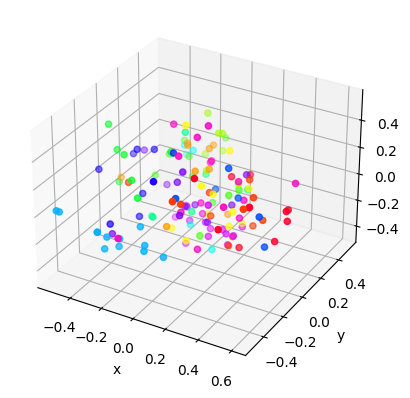

start epoch 2
current learning rate is: 5e-05
50
100
150
200
250
300
350
Epoch: 2/80 - Training Loss: 0.14


Steps: 0it [00:00, ?it/s]

Training success rate: 0.79


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.69


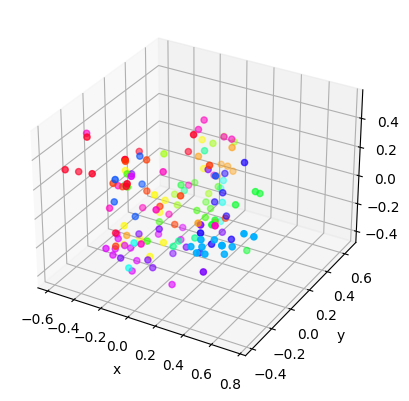

start epoch 3
current learning rate is: 5e-05
50
100
150
200
250
300
350
Epoch: 3/80 - Training Loss: 0.14


Steps: 0it [00:00, ?it/s]

Training success rate: 0.77


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


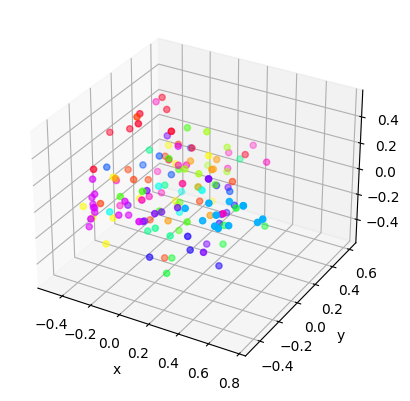

start epoch 4
current learning rate is: 5e-05
50
100
150
200
250
300
350
Epoch: 4/80 - Training Loss: 0.14


Steps: 0it [00:00, ?it/s]

Training success rate: 0.78


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


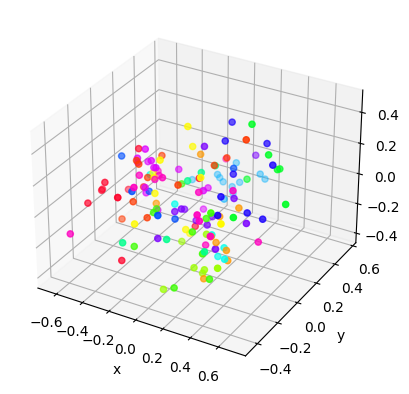

start epoch 5
current learning rate is: 2.5e-05
50
100
150
200
250
300
350
Epoch: 5/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.78


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.68


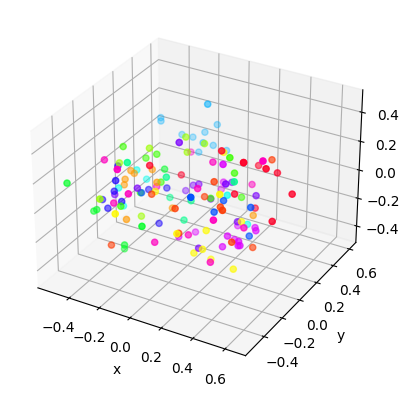

start epoch 6
current learning rate is: 2.5e-05
50
100
150
200
250
300
350
Epoch: 6/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.79


Steps: 0it [00:00, ?it/s]

could not load a file
Error message: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0
Validation success rate: 0.71


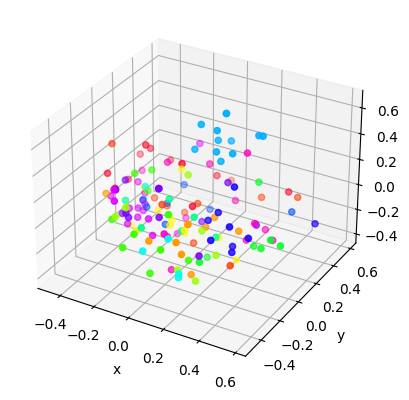

start epoch 7
current learning rate is: 2.5e-05
50
100
150
200
250
300
350
Epoch: 7/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.80


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


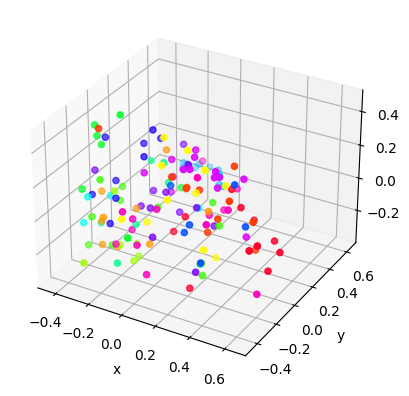

start epoch 8
current learning rate is: 1.25e-05
50
100
150
200
250
300
350
Epoch: 8/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.78


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.72


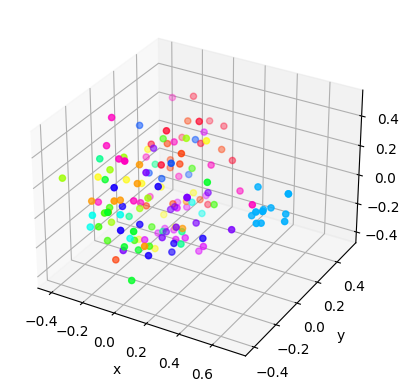

start epoch 9
current learning rate is: 1.25e-05
50
100
150
200
250
300
350
Epoch: 9/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

could not load a file
Error message: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0
Validation success rate: 0.71


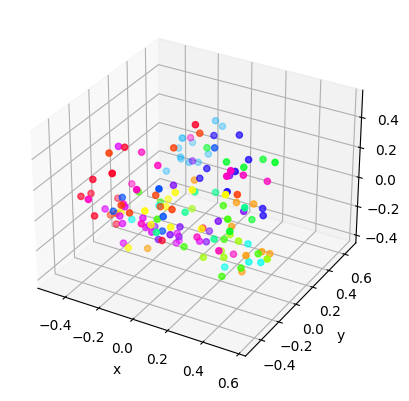

start epoch 10
current learning rate is: 6.25e-06
50
100
150
200
250
300
350
Epoch: 10/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


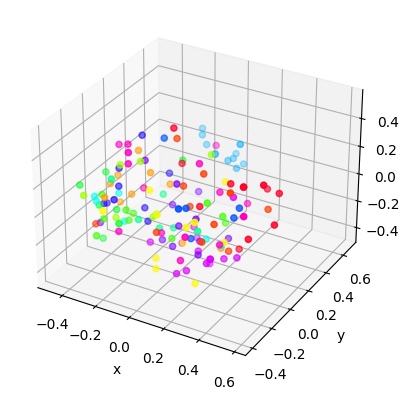

start epoch 11
current learning rate is: 6.25e-06
50
100
150
200
250
300
350
Epoch: 11/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.73


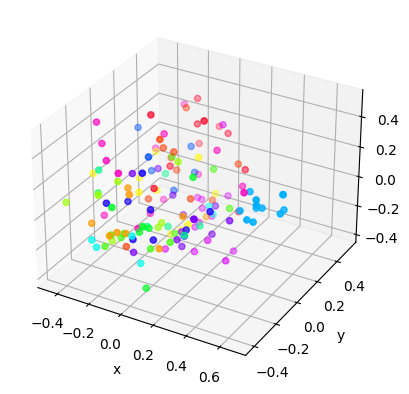

start epoch 12
current learning rate is: 6.25e-06
50
100
150
200
250
300
350
Epoch: 12/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.79


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


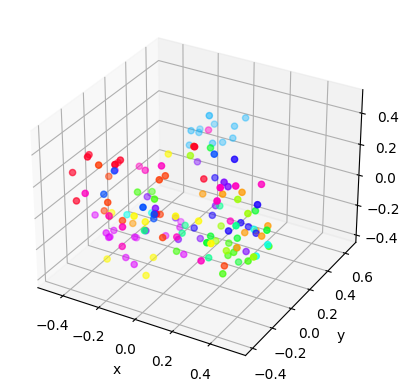

start epoch 13
current learning rate is: 3.125e-06
50
100
150
200
250
300
350
Epoch: 13/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.80


Steps: 0it [00:00, ?it/s]

could not load a file
Error message: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0
Validation success rate: 0.72


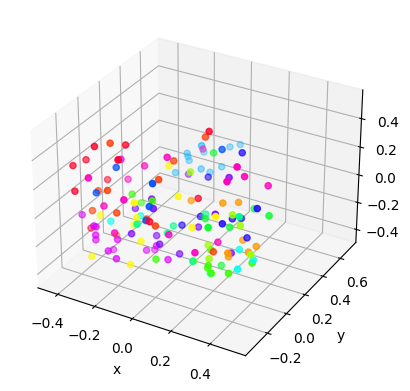

start epoch 14
current learning rate is: 3.125e-06
50
100
150
200
250
300
350
Epoch: 14/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.81


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


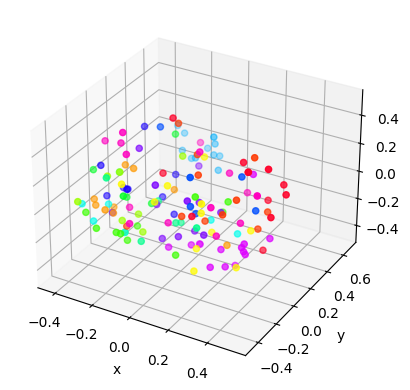

start epoch 15
current learning rate is: 1.5625e-06
50
100
150
200
250
300
350
Epoch: 15/80 - Training Loss: 0.11


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.72


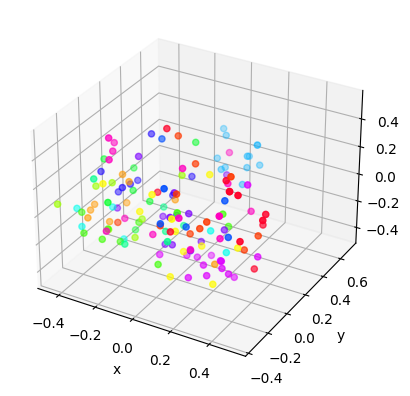

start epoch 16
current learning rate is: 1.5625e-06
50
100
150
200
250
300
350
Epoch: 16/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.81


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.72


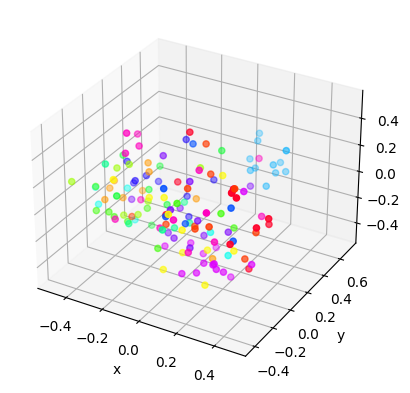

start epoch 17
current learning rate is: 7.8125e-07
50
100
150
200
250
300
350
Epoch: 17/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.81


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


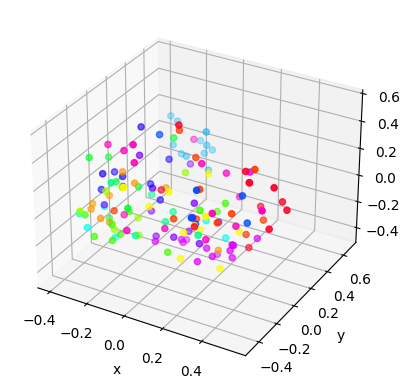

start epoch 18
current learning rate is: 7.8125e-07
50
100
150
200
250
300
350
Epoch: 18/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.71


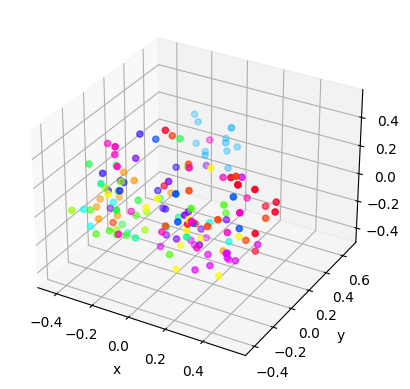

Patience ran out, early stopping now...


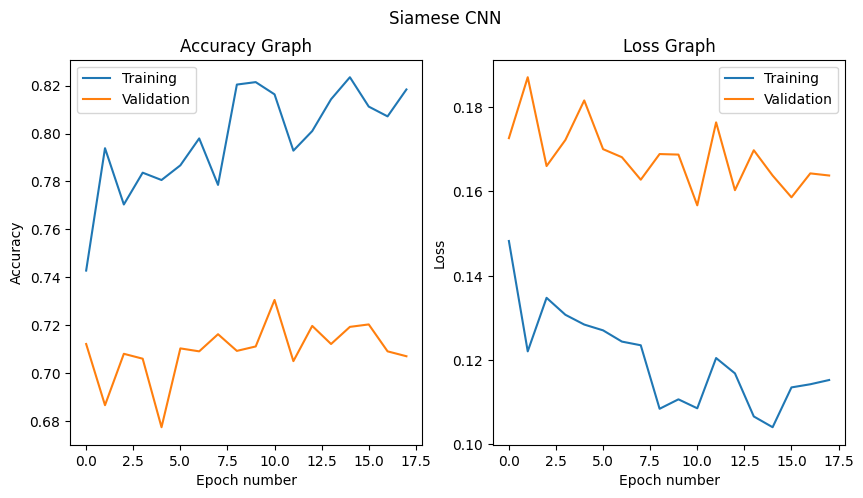

In [47]:
validation_data_frame = pd.read_pickle(f"../Data/Variables/validation_data_frame.pkl")
epochs = 80
batch_size = 20
current_training_zip="train"
hard_batch = False
if True:
        train_data_frame0 = pd.read_pickle(f"../Data/Variables/train_data_frame{0}.pkl")
        train_data_frame1 = pd.read_pickle(f"../Data/Variables/train_data_frame{1}.pkl")
        train_data_frame2 = pd.read_pickle(f"../Data/Variables/train_data_frame{2}.pkl")
        train_data_frame3 = pd.read_pickle(f"../Data/Variables/train_data_frame{3}.pkl")
        train_data_frame4 = pd.read_pickle(f"../Data/Variables/train_data_frame{4}.pkl")
        train_data_frame5 = pd.read_pickle(f"../Data/Variables/train_data_frame{5}.pkl")
        train_data_frame6 = pd.read_pickle(f"../Data/Variables/train_data_frame{6}.pkl")
        train_data_frame7 = pd.read_pickle(f"../Data/Variables/train_data_frame{7}.pkl")
        train_data_frame8 = pd.read_pickle(f"../Data/Variables/train_data_frame{8}.pkl")
        train_data_frame9 = pd.read_pickle(f"../Data/Variables/train_data_frame{9}.pkl")
        train_data_frame = pd.concat([train_data_frame0, train_data_frame1, train_data_frame2, train_data_frame3, train_data_frame4, train_data_frame5, train_data_frame6, train_data_frame7, train_data_frame8, train_data_frame9])
        model = FinalNetwork()
        model_name = "FinalNet"
        print("Starting the training of the super model, which contains 10 pre-trained sub-models:\n")
        train(train_data_frame, validation_data_frame, model, model_name, epochs, batch_size, current_training_zip, hard_batch, step_break=400)

else:
    for i in range(5, 10):
        train_data_frame = pd.read_pickle(f"../Data/Variables/train_data_frame{i}.pkl")
        model = Network2()
        model_name = f"Net{i}"
        train(train_data_frame, validation_data_frame, model, model_name, epochs, batch_size, current_training_zip, hard_batch)

start epoch 1
current learning rate is: 5e-05
50
100
Epoch: 1/80 - Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success rate: 0.70


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.69


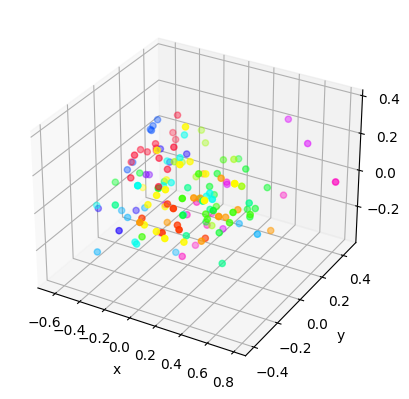

start epoch 2
current learning rate is: 5e-05
50
100
Epoch: 2/80 - Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success rate: 0.72


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.73


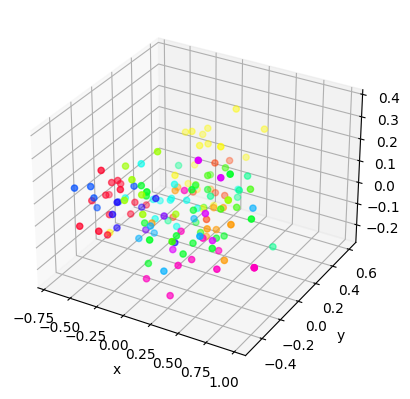

start epoch 3
current learning rate is: 5e-05
50
100
Epoch: 3/80 - Training Loss: 0.16


Steps: 0it [00:00, ?it/s]

Training success rate: 0.75


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.76


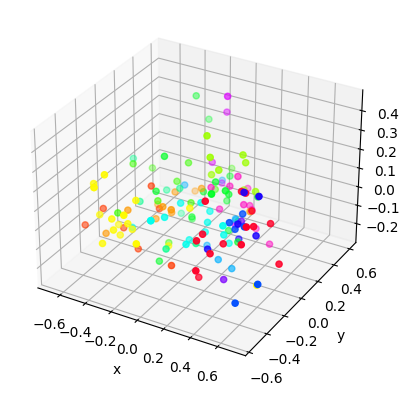

start epoch 4
current learning rate is: 5e-05
50
100
Epoch: 4/80 - Training Loss: 0.15


Steps: 0it [00:00, ?it/s]

Training success rate: 0.78


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.76


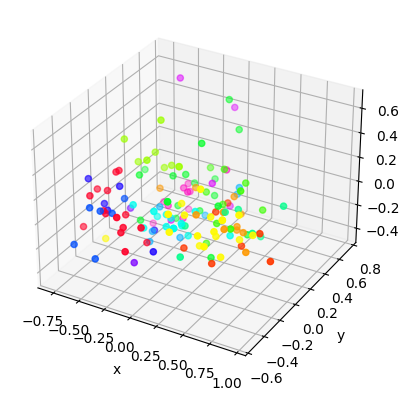

start epoch 5
current learning rate is: 5e-05
50
100
Epoch: 5/80 - Training Loss: 0.14


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.80


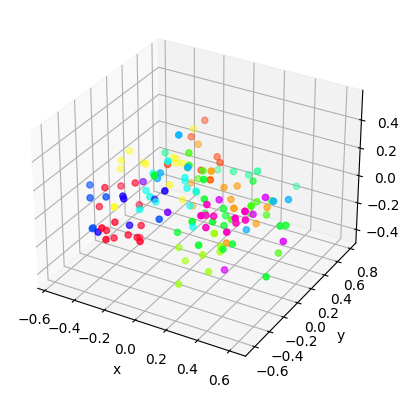

start epoch 6
current learning rate is: 5e-05
50
100
Epoch: 6/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.78


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.78


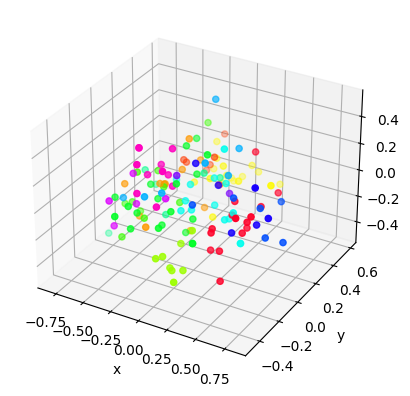

start epoch 7
current learning rate is: 5e-05
50
100
Epoch: 7/80 - Training Loss: 0.10


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.83


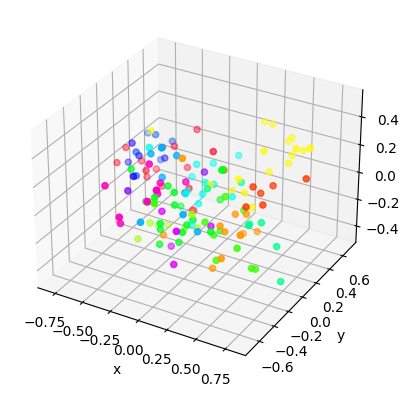

start epoch 8
current learning rate is: 5e-05
50
100
Epoch: 8/80 - Training Loss: 0.10


Steps: 0it [00:00, ?it/s]

Training success rate: 0.83


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.82


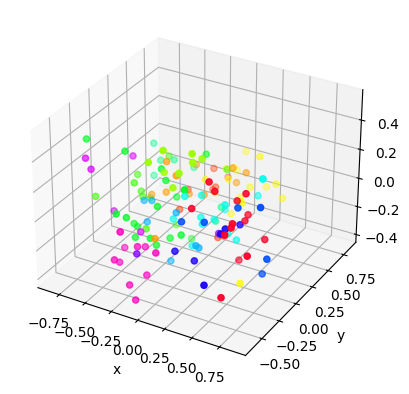

start epoch 9
current learning rate is: 5e-05
50
100
Epoch: 9/80 - Training Loss: 0.10


Steps: 0it [00:00, ?it/s]

Training success rate: 0.86


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.84


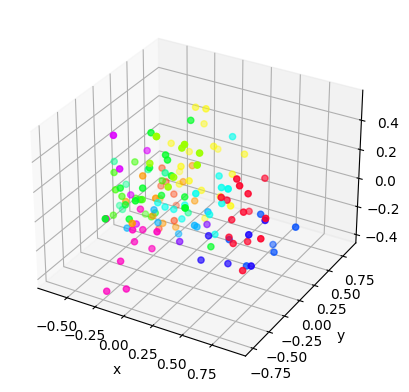

start epoch 10
current learning rate is: 2.5e-05
50
100
Epoch: 10/80 - Training Loss: 0.08


Steps: 0it [00:00, ?it/s]

Training success rate: 0.88


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.88


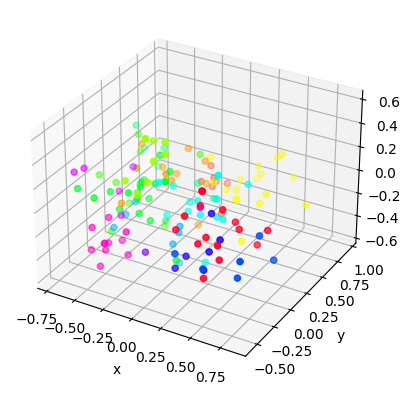

start epoch 11
current learning rate is: 2.5e-05
50
100
Epoch: 11/80 - Training Loss: 0.07


Steps: 0it [00:00, ?it/s]

Training success rate: 0.88


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.90


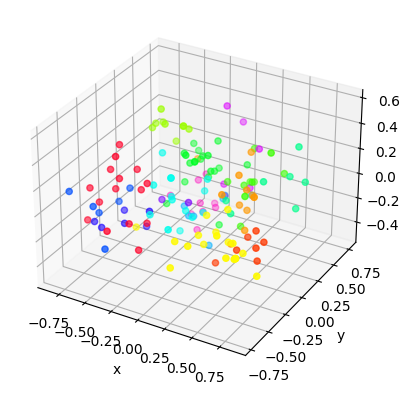

start epoch 12
current learning rate is: 2.5e-05
50
100
Epoch: 12/80 - Training Loss: 0.06


Steps: 0it [00:00, ?it/s]

Training success rate: 0.89


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.90


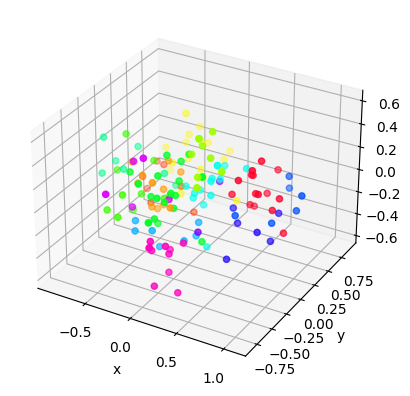

start epoch 13
current learning rate is: 2.5e-05
50
100
Epoch: 13/80 - Training Loss: 0.06


Steps: 0it [00:00, ?it/s]

Training success rate: 0.91


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.91


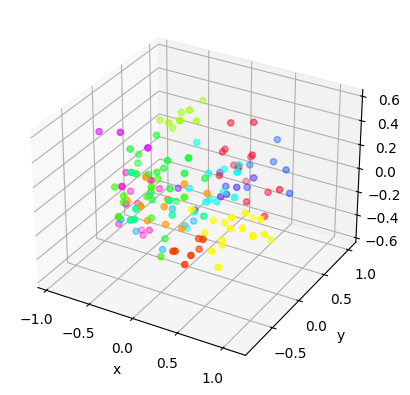

start epoch 14
current learning rate is: 2.5e-05
50
100
Epoch: 14/80 - Training Loss: 0.05


Steps: 0it [00:00, ?it/s]

Training success rate: 0.91


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.93


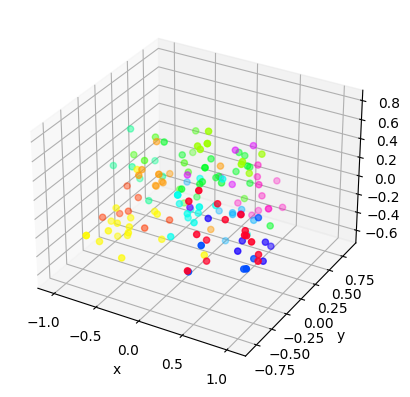

start epoch 15
current learning rate is: 2.5e-05
50
100
Epoch: 15/80 - Training Loss: 0.05


Steps: 0it [00:00, ?it/s]

Training success rate: 0.93


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.92


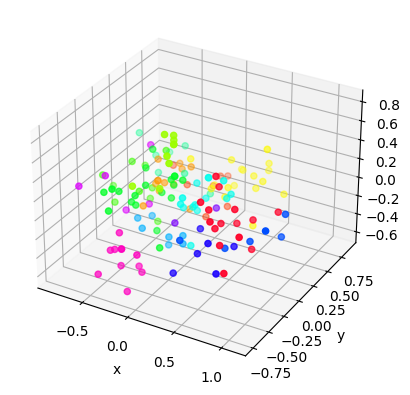

start epoch 16
current learning rate is: 2.5e-05
50
100
Epoch: 16/80 - Training Loss: 0.05


Steps: 0it [00:00, ?it/s]

Training success rate: 0.94


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.94


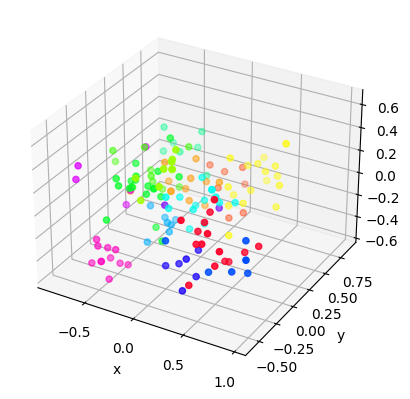

start epoch 1
current learning rate is: 5e-05
50
100
150
Epoch: 1/80 - Training Loss: 0.22


Steps: 0it [00:00, ?it/s]

Training success rate: 0.65


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.67


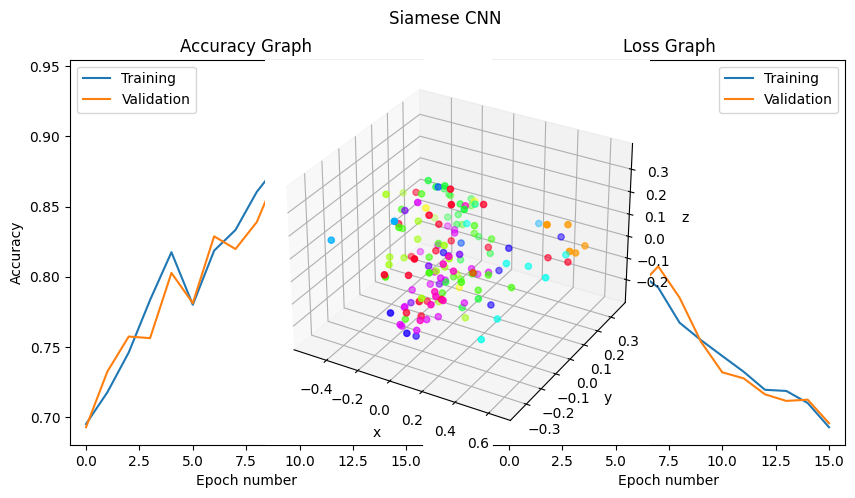

start epoch 2
current learning rate is: 5e-05
50
100
150
Epoch: 2/80 - Training Loss: 0.19


Steps: 0it [00:00, ?it/s]

Training success rate: 0.68


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.67


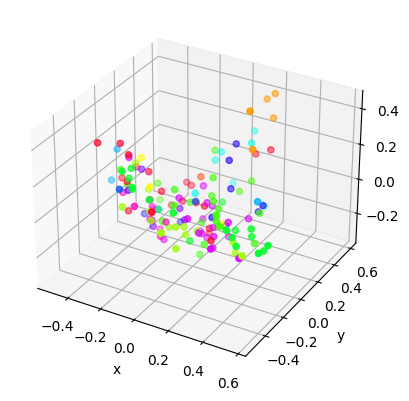

start epoch 3
current learning rate is: 5e-05
50
100
150
Epoch: 3/80 - Training Loss: 0.18


Steps: 0it [00:00, ?it/s]

Training success rate: 0.69


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.69


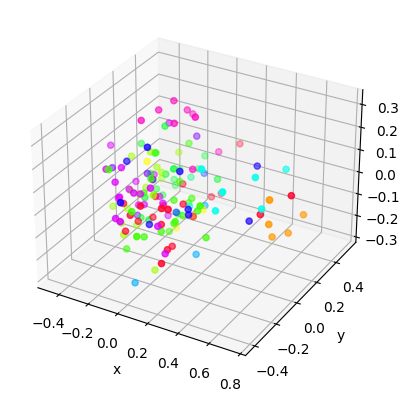

start epoch 4
current learning rate is: 5e-05
50
100
150
Epoch: 4/80 - Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success rate: 0.71


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.70


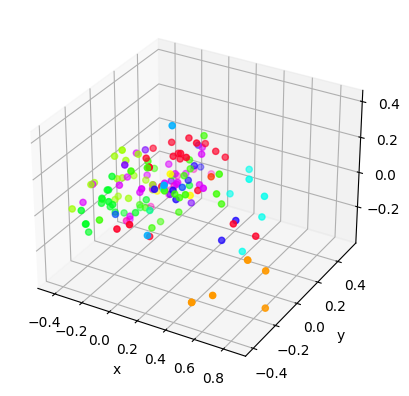

start epoch 5
current learning rate is: 5e-05
50
100
150
Epoch: 5/80 - Training Loss: 0.15


Steps: 0it [00:00, ?it/s]

Training success rate: 0.75


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.76


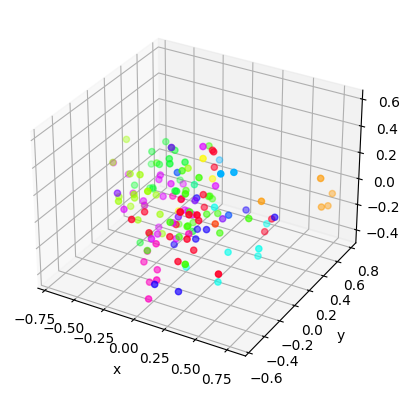

start epoch 6
current learning rate is: 5e-05
50
100
150
Epoch: 6/80 - Training Loss: 0.15


Steps: 0it [00:00, ?it/s]

Training success rate: 0.75


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.75


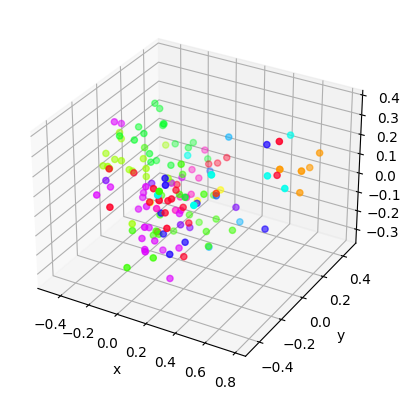

start epoch 7
current learning rate is: 5e-05
50
100
150
Epoch: 7/80 - Training Loss: 0.14


Steps: 0it [00:00, ?it/s]

Training success rate: 0.76


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.77


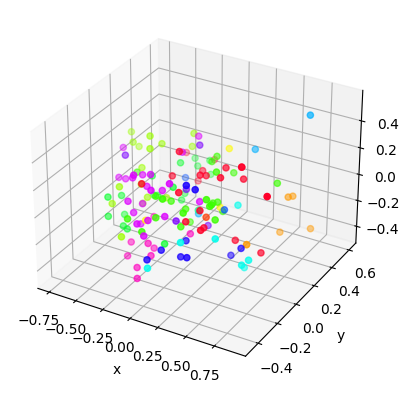

start epoch 8
current learning rate is: 2.5e-05
50
100
150
Epoch: 8/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.80


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.78


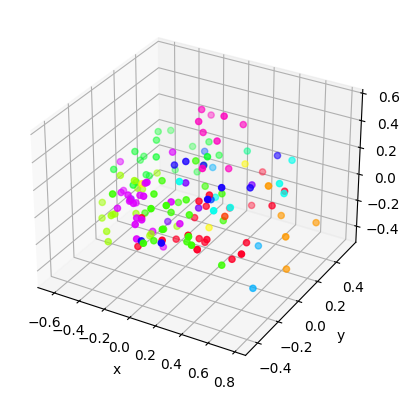

start epoch 9
current learning rate is: 2.5e-05
50
100
150
Epoch: 9/80 - Training Loss: 0.11


Steps: 0it [00:00, ?it/s]

Training success rate: 0.84


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.84


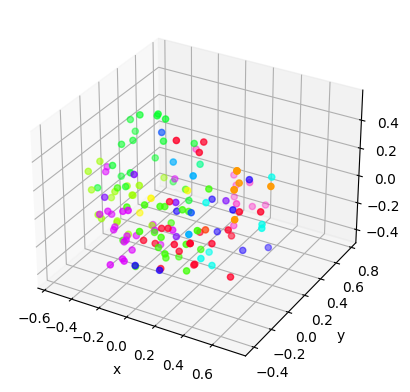

start epoch 10
current learning rate is: 2.5e-05
50
100
150
Epoch: 10/80 - Training Loss: 0.10


Steps: 0it [00:00, ?it/s]

Training success rate: 0.85


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.80


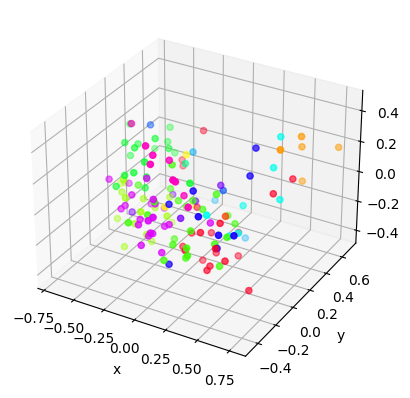

start epoch 11
current learning rate is: 2.5e-05
50
100
150
Epoch: 11/80 - Training Loss: 0.09


Steps: 0it [00:00, ?it/s]

Training success rate: 0.85


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.86


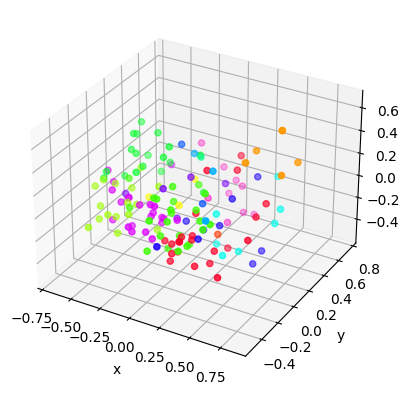

start epoch 12
current learning rate is: 2.5e-05
50
100
150
Epoch: 12/80 - Training Loss: 0.08


Steps: 0it [00:00, ?it/s]

Training success rate: 0.88


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.89


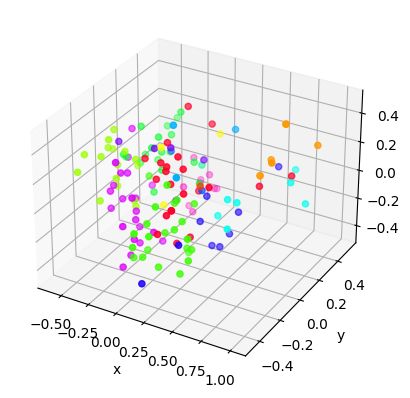

start epoch 13
current learning rate is: 2.5e-05
50
100
150
Epoch: 13/80 - Training Loss: 0.07


Steps: 0it [00:00, ?it/s]

Training success rate: 0.88


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.88


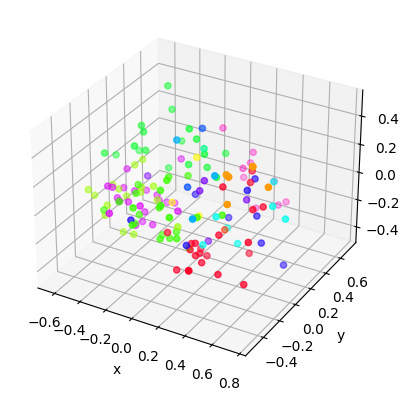

start epoch 14
current learning rate is: 2.5e-05
50
100
150
Epoch: 14/80 - Training Loss: 0.07


Steps: 0it [00:00, ?it/s]

Training success rate: 0.90


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.90


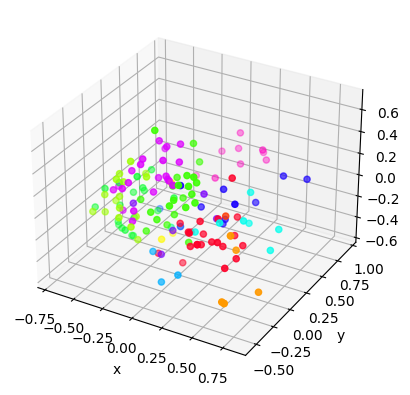

start epoch 15
current learning rate is: 2.5e-05
50
100
150
Epoch: 15/80 - Training Loss: 0.06


Steps: 0it [00:00, ?it/s]

Training success rate: 0.91


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.93


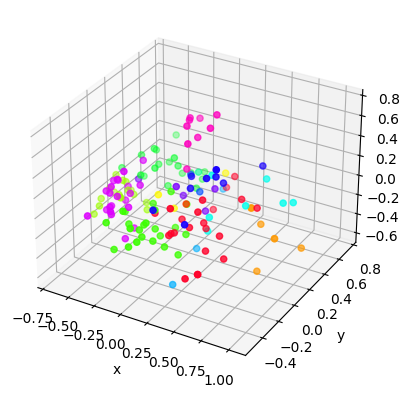

start epoch 16
current learning rate is: 2.5e-05
50
100
150
Epoch: 16/80 - Training Loss: 0.05


Steps: 0it [00:00, ?it/s]

Training success rate: 0.93


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.93


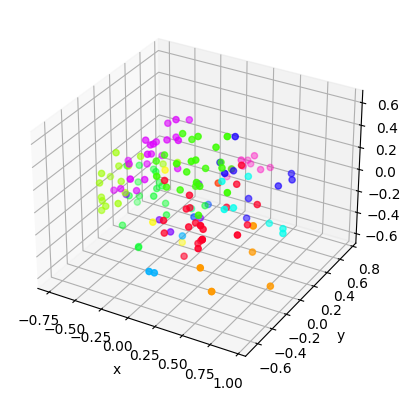

start epoch 1
current learning rate is: 5e-05
50
100
150
Epoch: 1/80 - Training Loss: 0.20


Steps: 0it [00:00, ?it/s]

Training success rate: 0.70


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.67


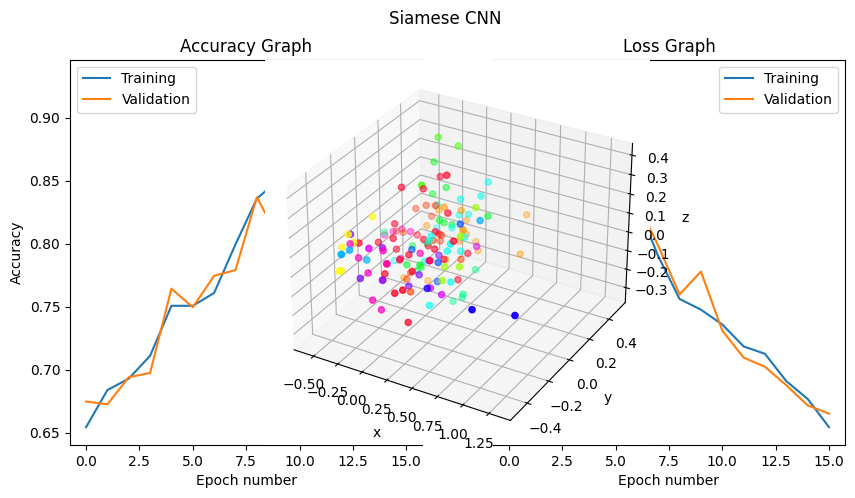

start epoch 2
current learning rate is: 5e-05
50
100
150
Epoch: 2/80 - Training Loss: 0.18


Steps: 0it [00:00, ?it/s]

Training success rate: 0.72


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.72


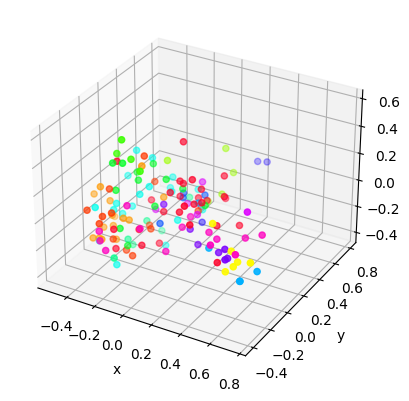

start epoch 3
current learning rate is: 5e-05
50
100
150
Epoch: 3/80 - Training Loss: 0.17


Steps: 0it [00:00, ?it/s]

Training success rate: 0.76


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.73


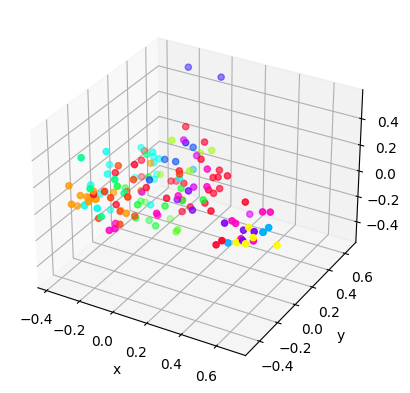

start epoch 4
current learning rate is: 5e-05
50
100
150
Epoch: 4/80 - Training Loss: 0.15


Steps: 0it [00:00, ?it/s]

Training success rate: 0.78


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.77


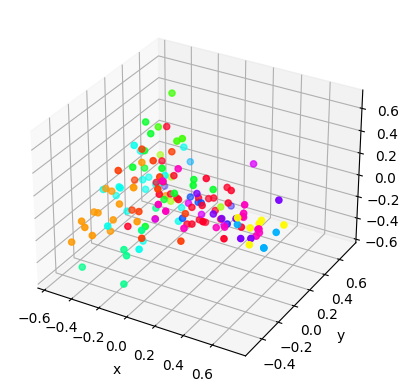

start epoch 5
current learning rate is: 5e-05
50
100
150
Epoch: 5/80 - Training Loss: 0.14


Steps: 0it [00:00, ?it/s]

Training success rate: 0.79


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.79


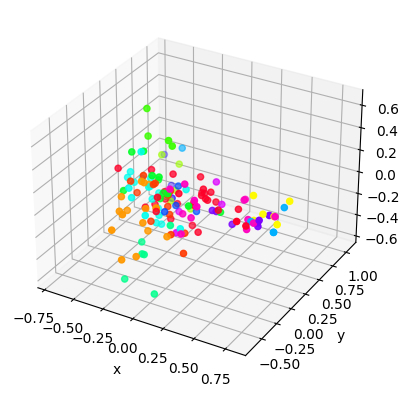

start epoch 6
current learning rate is: 5e-05
50
100
150
Epoch: 6/80 - Training Loss: 0.13


Steps: 0it [00:00, ?it/s]

Training success rate: 0.75


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.79


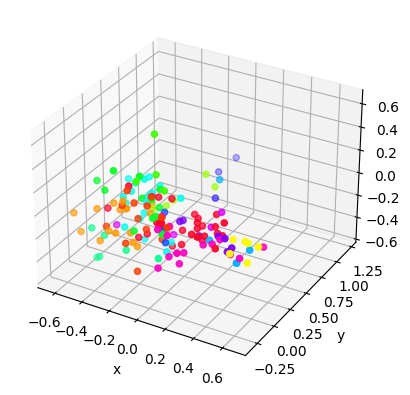

start epoch 7
current learning rate is: 5e-05
50
100
150
Epoch: 7/80 - Training Loss: 0.13


Steps: 0it [00:00, ?it/s]

Training success rate: 0.79


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.80


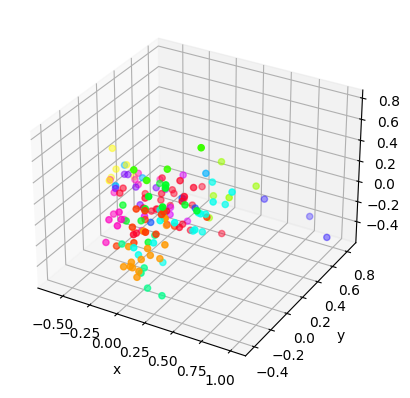

start epoch 8
current learning rate is: 5e-05
50
100
150
Epoch: 8/80 - Training Loss: 0.12


Steps: 0it [00:00, ?it/s]

Training success rate: 0.81


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.82


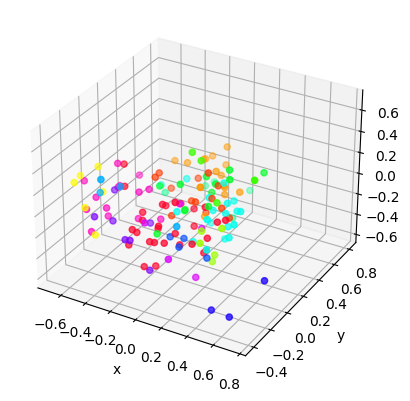

start epoch 9
current learning rate is: 5e-05
50
100
150
Epoch: 9/80 - Training Loss: 0.11


Steps: 0it [00:00, ?it/s]

Training success rate: 0.81


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.82


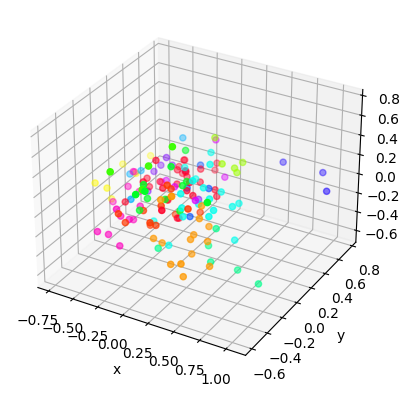

start epoch 10
current learning rate is: 5e-05
50
100
150
Epoch: 10/80 - Training Loss: 0.11


Steps: 0it [00:00, ?it/s]

Training success rate: 0.85


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.86


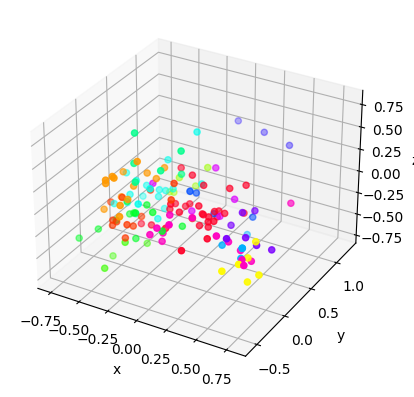

start epoch 11
current learning rate is: 5e-05
50
100
150
Epoch: 11/80 - Training Loss: 0.10


Steps: 0it [00:00, ?it/s]

Training success rate: 0.85


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.85


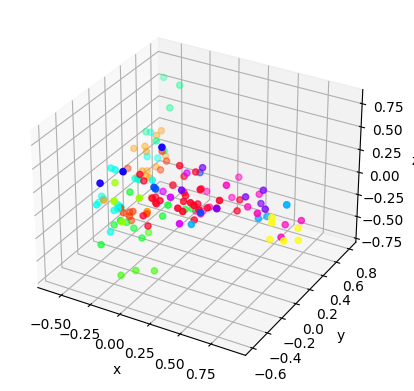

start epoch 12
current learning rate is: 5e-05
50
100
150
Epoch: 12/80 - Training Loss: 0.08


Steps: 0it [00:00, ?it/s]

Training success rate: 0.87


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.86


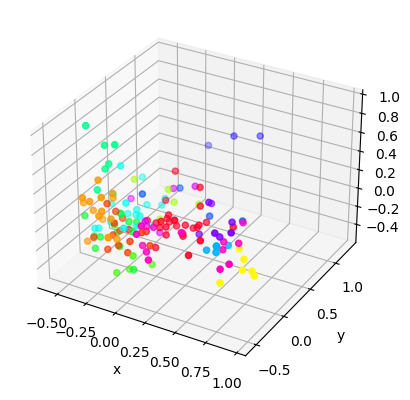

start epoch 13
current learning rate is: 5e-05
50
100
150
Epoch: 13/80 - Training Loss: 0.08


Steps: 0it [00:00, ?it/s]

Training success rate: 0.90


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.88


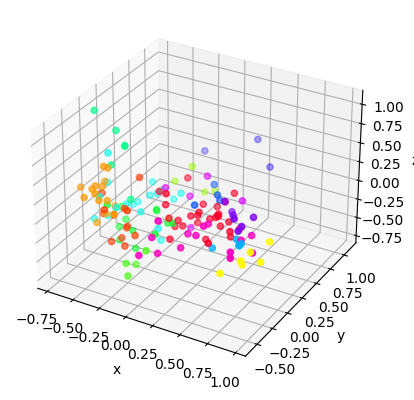

start epoch 14
current learning rate is: 5e-05
50
100
150
Epoch: 14/80 - Training Loss: 0.08


Steps: 0it [00:00, ?it/s]

Training success rate: 0.91


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.91


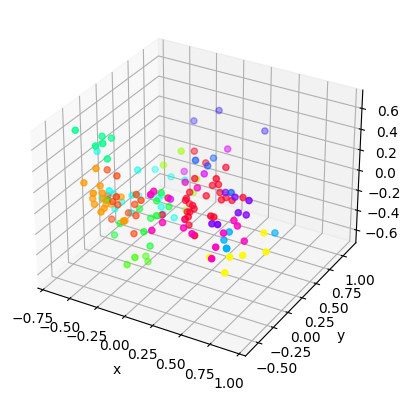

start epoch 15
current learning rate is: 5e-05
50
100
150
Epoch: 15/80 - Training Loss: 0.06


Steps: 0it [00:00, ?it/s]

Training success rate: 0.90


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.92


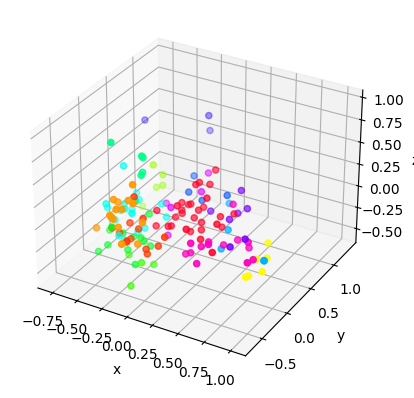

start epoch 16
current learning rate is: 5e-05
50
100
150
Epoch: 16/80 - Training Loss: 0.06


Steps: 0it [00:00, ?it/s]

Training success rate: 0.93


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.93


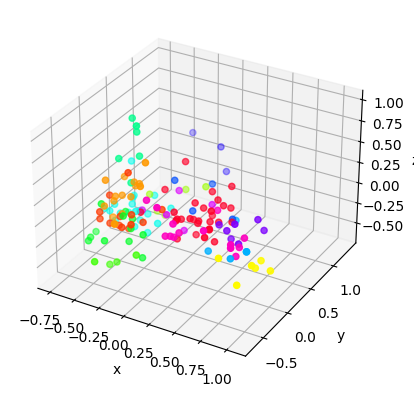

start epoch 1
current learning rate is: 5e-05
50
100
150
Epoch: 1/80 - Training Loss: 0.18


Steps: 0it [00:00, ?it/s]

Training success rate: 0.76


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.74


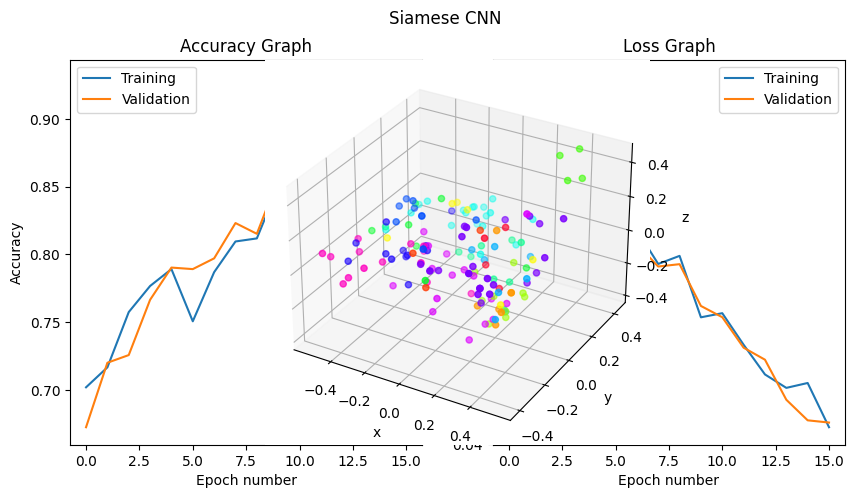

start epoch 2
current learning rate is: 5e-05
50
100
150
Epoch: 2/80 - Training Loss: 0.15


Steps: 0it [00:00, ?it/s]

Training success rate: 0.80


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.77


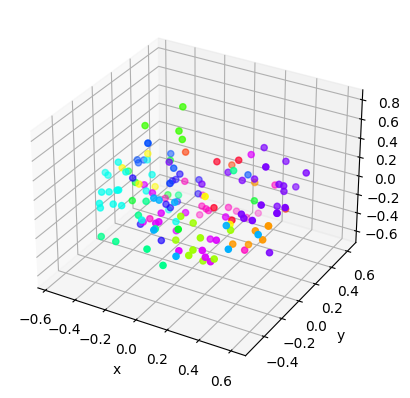

start epoch 3
current learning rate is: 5e-05
50
100
150
Epoch: 3/80 - Training Loss: 0.13


Steps: 0it [00:00, ?it/s]

Training success rate: 0.82


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.77


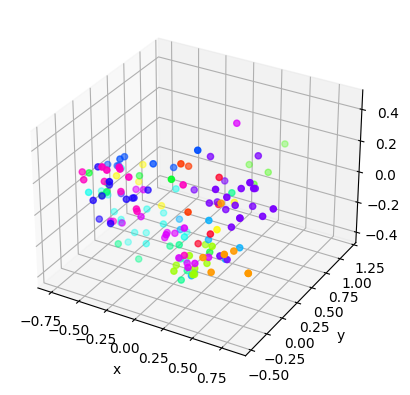

start epoch 4
current learning rate is: 5e-05
50
100
150
Epoch: 4/80 - Training Loss: 0.11


Steps: 0it [00:00, ?it/s]

Training success rate: 0.80


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.81


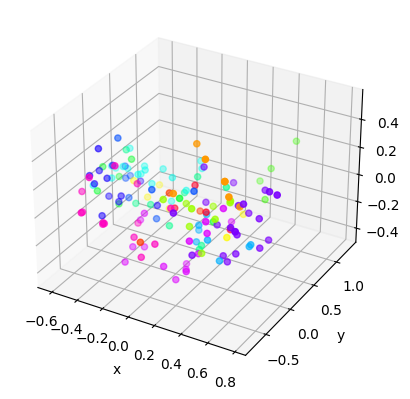

start epoch 5
current learning rate is: 5e-05
50
100
150
Epoch: 5/80 - Training Loss: 0.11


Steps: 0it [00:00, ?it/s]

Training success rate: 0.86


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.85


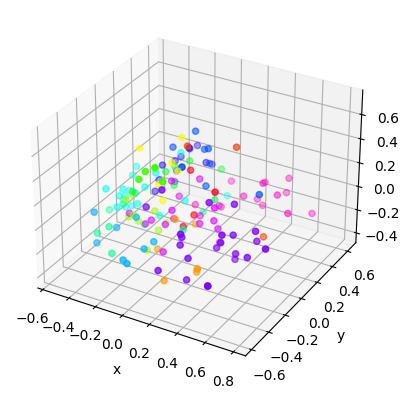

start epoch 6
current learning rate is: 5e-05
50
100
150
Epoch: 6/80 - Training Loss: 0.09


Steps: 0it [00:00, ?it/s]

Training success rate: 0.87


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.86


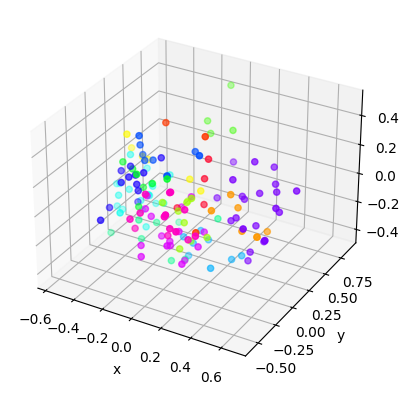

start epoch 7
current learning rate is: 5e-05
50
100
150
Epoch: 7/80 - Training Loss: 0.09


Steps: 0it [00:00, ?it/s]

Training success rate: 0.85


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.87


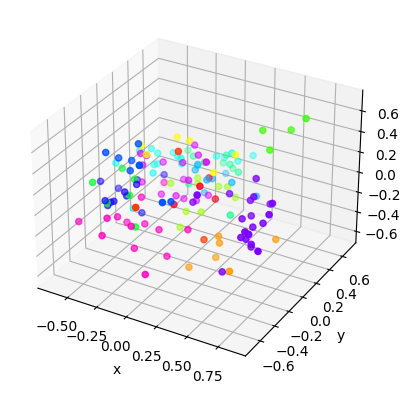

start epoch 8
current learning rate is: 5e-05
50
100
150
Epoch: 8/80 - Training Loss: 0.08


Steps: 0it [00:00, ?it/s]

Training success rate: 0.88


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.88


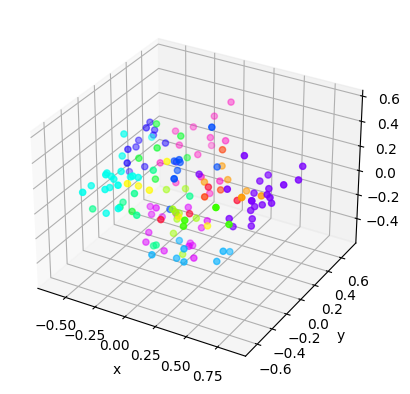

start epoch 9
current learning rate is: 5e-05
50
100
150
Epoch: 9/80 - Training Loss: 0.07


Steps: 0it [00:00, ?it/s]

Training success rate: 0.92


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.91


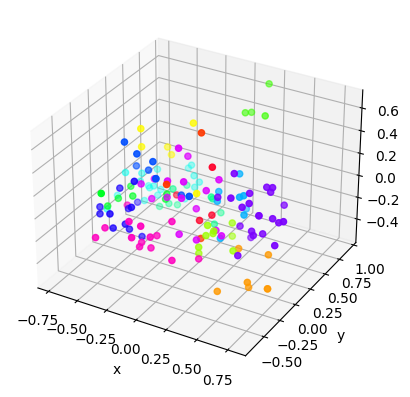

start epoch 10
current learning rate is: 5e-05
50
100
150
Epoch: 10/80 - Training Loss: 0.06


Steps: 0it [00:00, ?it/s]

Training success rate: 0.90


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.89


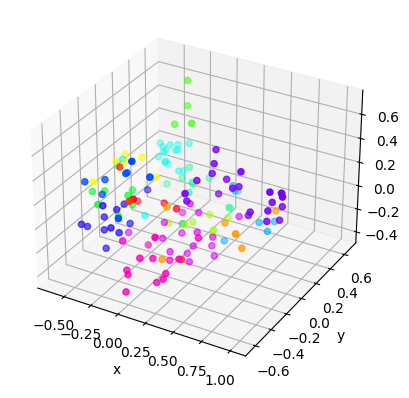

start epoch 11
current learning rate is: 5e-05
50
100
150
Epoch: 11/80 - Training Loss: 0.05


Steps: 0it [00:00, ?it/s]

Training success rate: 0.92


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.93


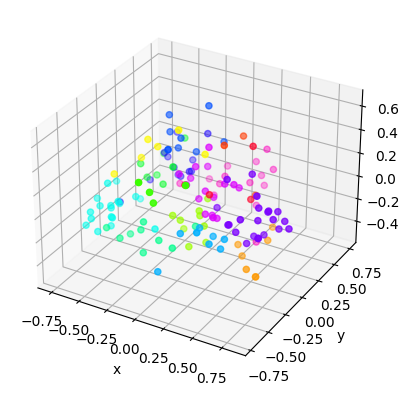

start epoch 12
current learning rate is: 5e-05
50
100
150
Epoch: 12/80 - Training Loss: 0.05


Steps: 0it [00:00, ?it/s]

Training success rate: 0.93


Steps: 0it [00:00, ?it/s]

Validation success rate: 0.94


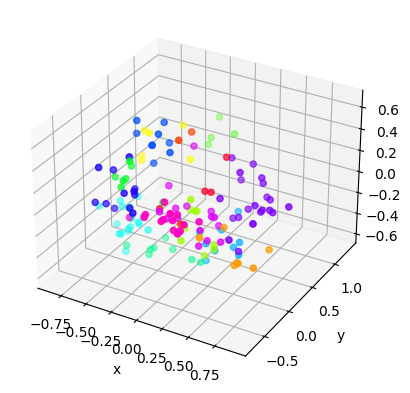

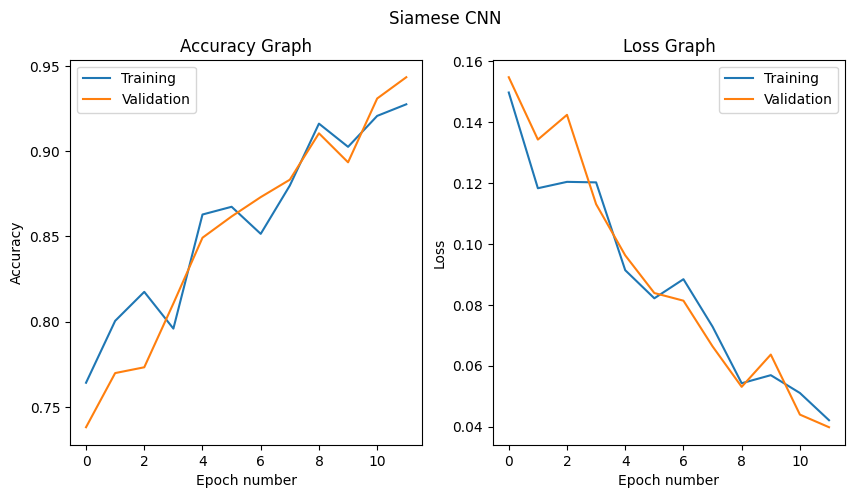

In [24]:
if False:
    current_validation_frame = pd.read_pickle(f"../Data/Variables/validation_data_frame.pkl")
    epochs = 80
    batch_size= 18
    current_training_zip = "train"
    hard_batch = False
    for i in range(6, 10):
        current_data_frame = pd.read_pickle(f"../Data/Variables/train_data_frame{i}.pkl")
        model = Network2()
        model_name = f"Net{i}"
        train(current_data_frame, current_validation_frame, model, model_name, epochs, batch_size, current_training_zip, hard_batch)

In [ ]:
torch.save({"model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
           }, "trained_model.pth")

Beginning an evaluation of the final model...



Steps: 0it [00:00, ?it/s]

Test success rate: 0.67


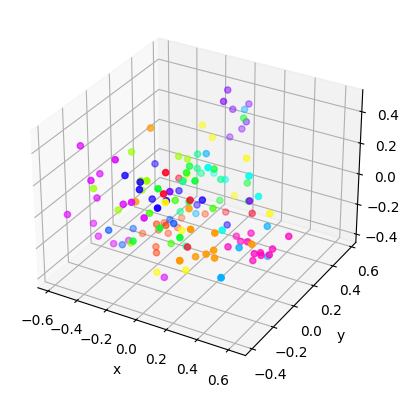

In [24]:
# prepare the test loader and send it with the examined model to the tester
def evaluation(model, criterion, data_frame=None, zip_name = "train"):

    if data_frame is None:
        test_loader_object = DoubleDataSet(zip_name, data_frame, fixed_res=True, res_size=256, is_train = False)
        test_loader = DataLoader(test_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
    else:
        test_loader_object = DoubleDataSet(zip_name, data_frame, fixed_res=True, res_size=256, is_train = False)
        test_loader = DataLoader(test_loader_object, batch_size=batch_size, num_workers=0, shuffle=True)
    test_run_pairs(test_loader, model, "test", criterion)
    # visualize the model outputs
    visualization_3d(model, test_loader_object)

if True:
    # Create a new instance of the model
    # Then we load the stored state of the model we want to evaluate
    test_data_frame = pd.read_pickle(f"../Data/Variables/test_data_frame.pkl")

    train_artists = list(train_data_frame["artist"].unique())
    mask = test_data_frame['artist'].isin(train_artists)
    test_data_frame = test_data_frame[~mask].reset_index(drop=True)

    batch_size = 8
    model = FinalNetwork()
    triplet_loss = TripletLoss(0.25).to(device)
    checkpoint = torch.load("../Data/Models/FinalNet.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    print("Beginning an evaluation of the final model...\n")
    evaluation(model.to(device), triplet_loss, test_data_frame, "test")